<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/Deteccion_de_peatones_kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###**Actividad 3.1 - Detección de Peatones con SVM**
Equipo 18:
- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204


In [2]:
#Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from xml.etree import ElementTree
import os
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
import cv2
import numpy as np

### Extracción de datos

In [3]:
#Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

In [ ]:
# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

In [ ]:
# Descargar el archivo del conjunto de datos de Kaggle (https://www.kaggle.com/datasets/karthika95/pedestrian-detection)
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset


Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
 93% 174M/187M [00:01<00:00, 141MB/s]
100% 187M/187M [00:01<00:00, 130MB/s]


In [ ]:
# Se definen los nombres de las clases
class_names = ['person', 'person-like']

# Se crea un diccionario que asigna un índice a cada nombre de clase

n_classes = 2
size = (200,200)

In [ ]:
#Función para cargar y procesar las imágenes y etiquetas desde los directorios específicos para conjuntos de datos de entrenamiento, prueba y validación
def load_data():
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = "/content/pedestrian_dataset/" + dataset +"/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset +"/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:

            xmlf = os.path.join(directoryA,xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i +=1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

      #  labels = pd.DataFrame(labels)
        labels = np.array(labels, dtype='int32')

        output.append((imags, labels))
    return output

In [ ]:
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [ ]:
train_images.shape

(944, 200, 200, 3)

###Exploración del dataset de entrenamiento

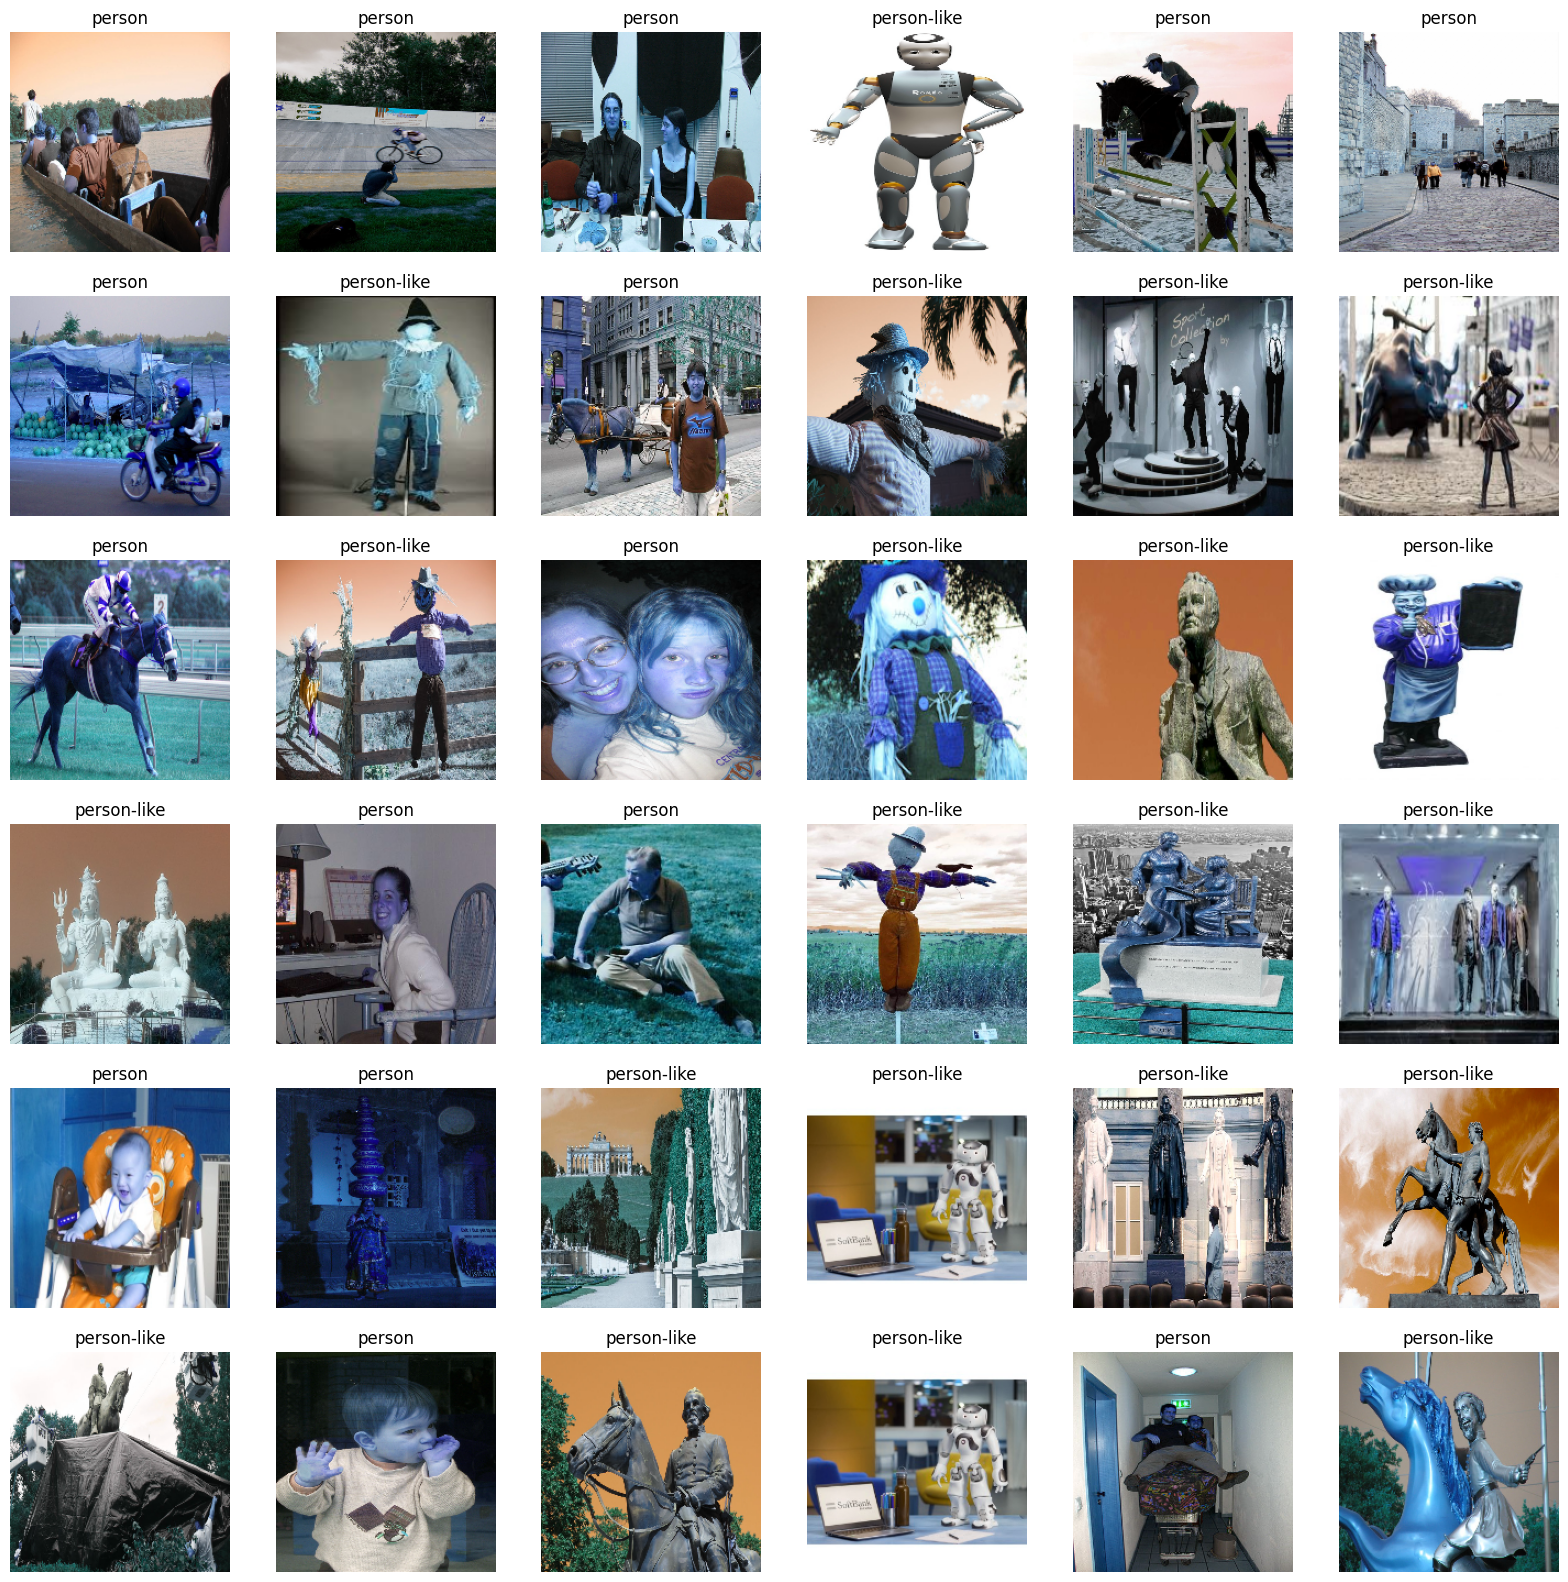

In [ ]:
# Se imprimen 36 imágenes aleatorias con su correspondiente etiqueta
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')

###Visualización de una imagen con peatones

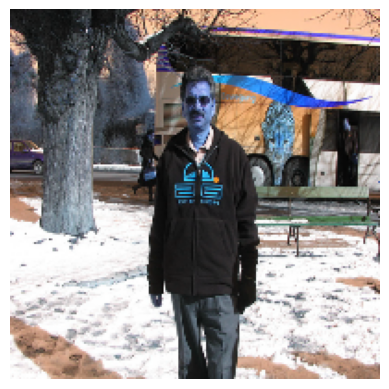

In [ ]:
plt.imshow(train_images[89])
plt.axis('off')
plt.show()


###Calculo del HOG de la Imagen

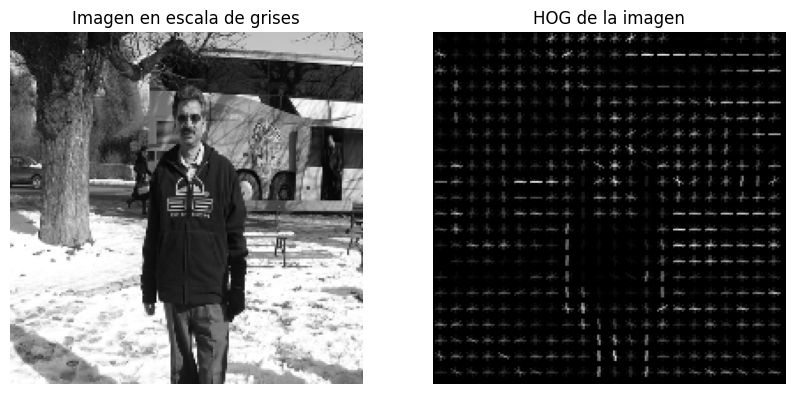

In [ ]:
# Leer la imagen en color
img_color = train_images[89]

# Convertir la imagen a escala de grises
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Calcular el HOG
features, hog_img = hog(img_gray,
                        orientations=5,
                        pixels_per_cell=(9, 9),
                        cells_per_block=(2, 2),
                        transform_sqrt=False,
                        visualize=True,
                        feature_vector=True)

# Mostrar la imagen original y el HOG
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Imagen en escala de grises')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG de la imagen')
plt.axis('off')

plt.show()

### Se extraen las features del HOG

Se extraen las HOG features para el conjunto de datos de entrenamiento

In [ ]:
train_features_accum = []

for i in train_images:
    img_color = i
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)

    features, hog_img = hog(img_gray,
                            orientations = 5,
                            pixels_per_cell = (9,9),
                            cells_per_block = (2,2),
                            transform_sqrt = False,
                            visualize = True,
                            feature_vector = True)

    train_features_accum.append(features)

In [ ]:
train_features = np.vstack(train_features_accum).astype(np.float64)
print("Shape de X train_features:", train_features.shape)
print("Shape de Y train_labels:", train_labels.shape)

Shape de X train_features: (944, 8820)
Shape de Y train_labels: (944,)


Se extraen las HOG features para el conjunto de datos de Validación

In [ ]:
test_features_accum = []

for i in test_images:
    img_color = i
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)

    features, hog_img = hog(img_gray,
                            orientations = 5,
                            pixels_per_cell = (9,9),
                            cells_per_block = (2,2),
                            transform_sqrt = False,
                            visualize = True,
                            feature_vector = True)

    test_features_accum.append(features)

In [ ]:
test_features = np.vstack(test_features_accum).astype(np.float64)
print("Shape de X test_features:", test_features.shape)
print("Shape de Y test_labels:", test_labels.shape)

Shape de X test_features: (235, 8820)
Shape de Y test_labels: (235,)


###GridSearchCV
Implementación de GridSearchCV para la búsqueda de los mejores hiperparametros para la SVM

In [ ]:
# Definición de los parámetros a buscar
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Inicialización del clasificador SVC
svm_model = SVC()

# Búsqueda de hiperparámetros con GridSearchCV
#grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search = GridSearchCV(svm_model,param_grid,refit=True,verbose=4)
grid_search.fit(train_features, train_labels)

# Obtención del mejor modelo y sus hiperparámetros
best_svm_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Imprime los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.651 total time=   5.0s
[CV 2/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.640 total time=   5.2s
[CV 3/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.725 total time=   4.9s
[CV 4/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.704 total time=   4.9s
[CV 5/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.670 total time=   5.3s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.566 total time=   5.5s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.566 total time=   6.2s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.566 total time=   6.3s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.561 total time=   5.5s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.564 total time=   6.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.651 total time=   4.9s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

##Entrenamiento del modelo

Entrenamiento del modelo con los mejores hiperparametros

In [ ]:
best_params

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
best_svm_model

SVC(C=10, gamma=0.01)

In [ ]:
# Predicción de etiquetas del conjunto de datos de validación
test_predictions = best_svm_model.predict(test_features)

# Cálculo del accuracy del modelo
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy del modelo:", accuracy)

Accuracy del modelo: 0.7361702127659574


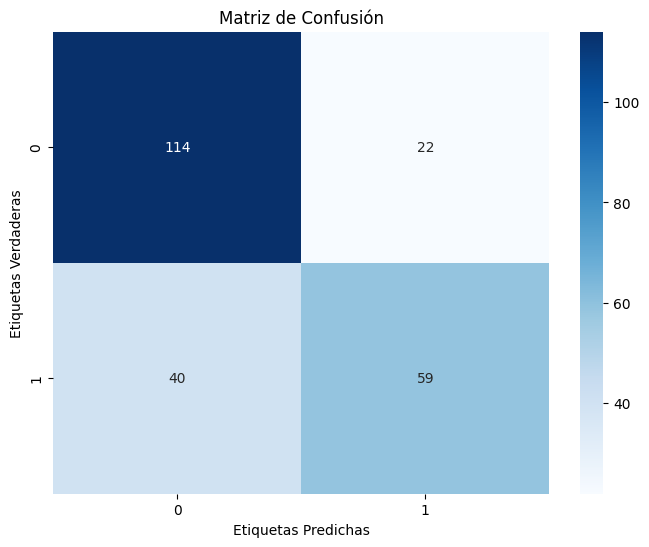

In [ ]:
# Cálculo la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Imprime la matriz de confusión de forma visual
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

In [ ]:
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       136
           1       0.73      0.60      0.66        99

    accuracy                           0.74       235
   macro avg       0.73      0.72      0.72       235
weighted avg       0.74      0.74      0.73       235

